### Importación de Librerías y Carga de Datos

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from campos import Campos

# Configuración de estilo para las gráficas
sns.set_theme(style="whitegrid", rc={'figure.figsize': (10, 6)})

# CARGA DE DATOS
file_path = 'sistematizacion/base_de_datos.xlsx' 

# Leemos el excel
df = pd.read_excel(file_path)

print("Primeras 5 filas crudas (sin limpiar):")
print(df.head())

Primeras 5 filas crudas (sin limpiar):
  Unidad Sitio_ID      Fecha      Hora             Clasificacion    Habito  \
0     U5     U5R3 2025-10-08  11:12:00       Muhlenbergia rigens   Arbusto   
1     U5     U5R3 2025-10-08  11:12:00       Género - Lepechinia  Herbacea   
2     U5     U5R3 2025-10-08  11:12:00  Subfamilia - Asteroideae  Herbacea   
3     U5     U5R3 2025-10-08  11:12:00         Familia - Poaceae  Herbacea   
4     U5     U5R3 2025-10-08  11:12:00                  Pegapeas  Herbacea   

   Num_Flores  Num_Arbustos  Area_m2  
0           0             2        4  
1           0             0        4  
2           0             0        4  
3           0             0        4  
4          91             0        4  


### Limpieza y Sistematización

In [ ]:
# 1. CONVERSIÓN DE FECHA A DATETIME
df[Campos.FECHA.value] = pd.to_datetime(df[Campos.FECHA.value])
PESO_FLORES = 1
PESO_ARBUSTOS = 1

# 2. CÁLCULO DE DENSIDAD PONDERADA POR FILA
# Ponderación: (Num_Flores * PESO_FLORES) + (Num_Arbustos * PESO_ARBUSTOS)
# Los arbustos tienen más peso porque son recursos más permanentes y valiosos
df['Recursos_Ponderados'] = (df[Campos.NUM_FLORES.value] * PESO_FLORES) + (df[Campos.NUM_ARBUSTOS.value] * PESO_ARBUSTOS)

# Densidad: Recursos ponderados / área
df[Campos.DENSIDAD_PONDERADA.value] = df['Recursos_Ponderados'] / df[Campos.AREA_M2.value]

# 3. AGREGACIÓN POR SITIO
# Sumamos todos los recursos por sitio y calculamos la densidad total
df_sitios = df.groupby([Campos.SITIO_ID.value, Campos.UNIDAD.value, Campos.FECHA.value]).agg({
    Campos.NUM_FLORES.value: 'sum',
    Campos.NUM_ARBUSTOS.value: 'sum',
    'Recursos_Ponderados': 'sum',
    Campos.AREA_M2.value: 'first',
    Campos.DENSIDAD_PONDERADA.value: 'sum'
}).reset_index()

print("Tabla procesada lista para análisis (Una fila por Sitio):")
print(df_sitios.head(10))
print(f"\nTotal de sitios: {len(df_sitios)}")
print(f"Unidades únicas: {df_sitios[Campos.UNIDAD.value].nunique()}")
print(f"Fechas únicas: {df_sitios[Campos.FECHA.value].nunique()}")

Tabla procesada lista para análisis (Una fila por Sitio):
  Sitio_ID Unidad      Fecha  Num_Flores  Num_Arbustos  Recursos_Ponderados  \
0    U10R2    U10 2025-11-10         210             1                  220   
1    U10R3    U10 2025-11-10         156             0                  156   
2    U10R4    U10 2025-11-10         107             0                  107   
3    U10R6    U10 2025-11-10         387             0                  387   
4    U11R1    U11 2025-11-19        4025            14                 4165   
5    U11R6    U11 2025-11-19       20445             2                20465   
6    U11R7    U11 2025-11-19       13240            11                13350   
7    U11R8    U11 2025-11-19        1858            24                 2098   
8    U12R1    U12 2025-11-10           0             5                   50   
9    U12R2    U12 2025-11-10           5             4                   45   

   Area_m2  Densidad_Ponderada  
0        4               55.00  
1     

### Estadísticas Descriptivas y Gráficas

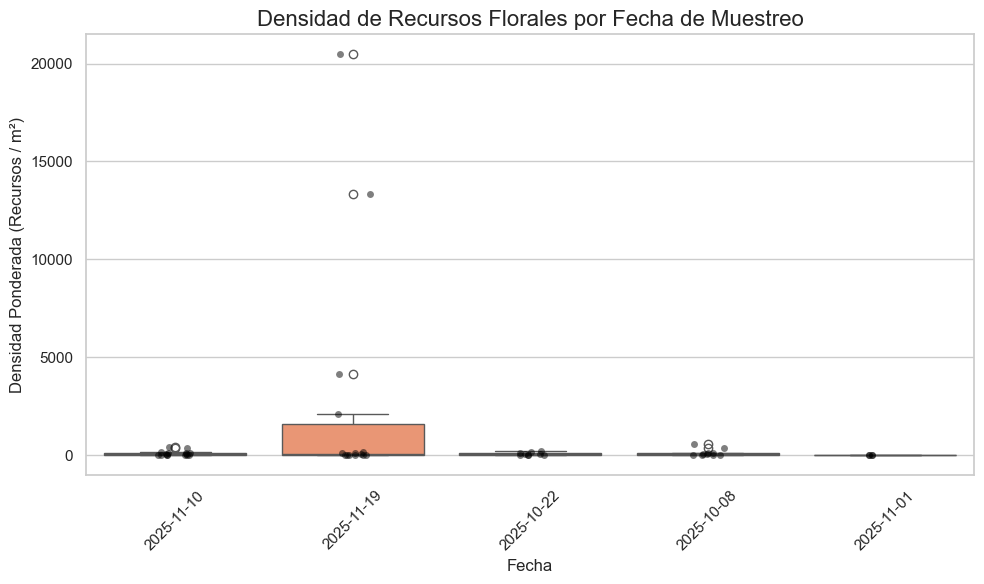

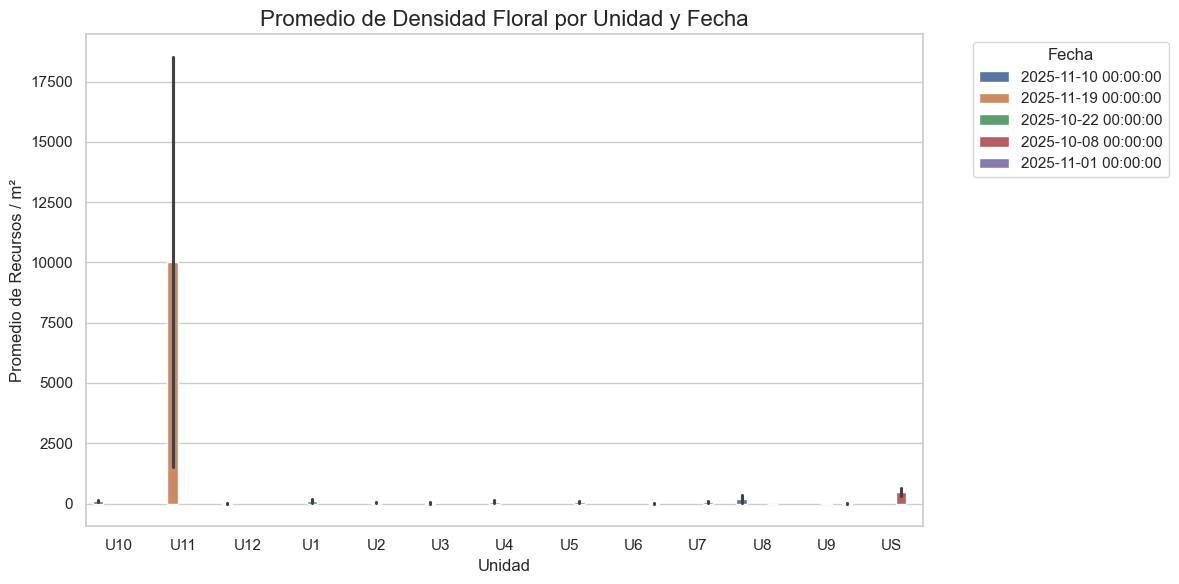

In [7]:
# GRÁFICA 1: Boxplot (Cajas y Bigotes)
# Ideal para ver la caída de flores a través del tiempo y la variabilidad
plt.figure(figsize=(10, 6))
sns.boxplot(x=Campos.FECHA.value, y=Campos.DENSIDAD_PONDERADA.value, data=df_sitios, hue=Campos.FECHA.value, palette="Set2", legend=False)
sns.stripplot(x=Campos.FECHA.value, y=Campos.DENSIDAD_PONDERADA.value, data=df_sitios, color='black', alpha=0.5, jitter=True)

plt.title('Densidad de Recursos Florales por Fecha de Muestreo', fontsize=16)
plt.ylabel('Densidad Ponderada (Recursos / m²)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# GRÁFICA 2: Comparación por Unidad (Para ver el efecto espacial)
plt.figure(figsize=(12, 6))
sns.barplot(x=Campos.UNIDAD.value, y=Campos.DENSIDAD_PONDERADA.value, hue=Campos.FECHA.value, data=df_sitios, errorbar='sd')
plt.title('Promedio de Densidad Floral por Unidad y Fecha', fontsize=16)
plt.ylabel('Promedio de Recursos / m²', fontsize=12)
plt.legend(title='Fecha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Modelo Lineal Mixto (LMM)

In [8]:
# MODELO LINEAL MIXTO (LMM)
# 
# ¿Qué hace este modelo?
# -----------------------
# Analiza cómo la DENSIDAD DE RECURSOS FLORALES cambia en el TIEMPO,
# mientras controla por la VARIABILIDAD ESPACIAL entre unidades.
#
# Componentes:
# • Variable Respuesta: Densidad_Ponderada (recursos/m²)
# • Efecto Fijo: Fecha → Mide el cambio temporal (¿baja la disponibilidad con el tiempo?)
# • Efecto Aleatorio: Unidad → Controla que U1, U2, U3... tengan diferentes "bases"
#
# ¿Por qué mixto?
# Porque combina efectos FIJOS (tiempo, igual para todos) con efectos ALEATORIOS
# (cada unidad tiene su propio nivel base de recursos).

modelo = smf.mixedlm(
    f"{Campos.DENSIDAD_PONDERADA.value} ~ C({Campos.FECHA.value})", 
    df_sitios, 
    groups=df_sitios[Campos.UNIDAD.value]
)

try:
    resultado = modelo.fit()
    print(resultado.summary())
    
    # INTERPRETACIÓN
    print("\n" + "="*70)
    print("INTERPRETACIÓN DEL MODELO")
    print("="*70)
    
    # Coeficientes y p-values
    coefs = resultado.fe_params
    p_vals = resultado.pvalues
    
    print("\nEfectos de las fechas (comparado con la primera fecha):")
    print("-" * 70)
    for param, coef, pval in zip(coefs.index, coefs.values, p_vals.values):
        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "ns"
        print(f"{param:40} β={coef:8.3f}  p={pval:.4f} {sig}")
    
    print("\nSignificancia: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo")
    
    # Varianza aleatoria
    print(f"\nVarianza entre Unidades: {resultado.cov_re.values[0][0]:.3f}")
    print(f"Varianza Residual: {resultado.scale:.3f}")
    
except Exception as e:
    print(f"Error al ajustar el modelo: {e}")
    print("\nPosibles causas:")
    print("• Muy pocos datos")
    print("• Poca variabilidad entre unidades o fechas")
    print("• Problemas de convergencia numérica")

                              Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            Densidad_Ponderada
No. Observations:            52                 Method:                        REML              
No. Groups:                  13                 Scale:                         5699650.1355      
Min. group size:             2                  Log-Likelihood:                -445.0232         
Max. group size:             7                  Converged:                     Yes               
Mean group size:             4.0                                                                 
-------------------------------------------------------------------------------------------------
                                                Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------------------------
Intercept                                         